<a href="https://colab.research.google.com/github/alesha-ofc-he/DeepLerningHw1/blob/main/DeepLerningHomeWork1AlikhanKassymbekovIT2307.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Function to load MNIST dataset (for Problem 1 & 2)
def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Function to load CIFAR-10 dataset (for Problem 3)
def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
# Helper function to train a model
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_accuracies = []

    model.to(device)

    start_time = time.time()

    for epoch in range(epochs):
        model.train() # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Flatten images if using MLP (not for CNN)
            if isinstance(model, FlexibleMLP) or isinstance(model, DeepMLP):
                images = images.view(images.shape[0], -1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on test set
        acc = evaluate_model(model, test_loader)
        test_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Acc: {acc:.2f}%")

    total_time = time.time() - start_time
    return train_losses, test_accuracies, total_time

# Helper function to calculate accuracy
def evaluate_model(model, test_loader):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            if isinstance(model, FlexibleMLP) or isinstance(model, DeepMLP):
                images = images.view(images.shape[0], -1)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

100%|██████████| 9.91M/9.91M [00:00<00:00, 100MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 32.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 109MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.79MB/s]



Training with relu...
Epoch [1/10], Loss: 1.0130, Test Acc: 88.30%
Epoch [2/10], Loss: 0.3806, Test Acc: 90.65%
Epoch [3/10], Loss: 0.3233, Test Acc: 90.73%
Epoch [4/10], Loss: 0.2913, Test Acc: 91.96%
Epoch [5/10], Loss: 0.2662, Test Acc: 92.46%
Epoch [6/10], Loss: 0.2421, Test Acc: 93.46%
Epoch [7/10], Loss: 0.2208, Test Acc: 93.43%
Epoch [8/10], Loss: 0.2023, Test Acc: 93.81%
Epoch [9/10], Loss: 0.1868, Test Acc: 94.73%
Epoch [10/10], Loss: 0.1727, Test Acc: 94.87%

Training with sigmoid...
Epoch [1/10], Loss: 2.2950, Test Acc: 11.85%
Epoch [2/10], Loss: 2.2586, Test Acc: 39.32%
Epoch [3/10], Loss: 2.1586, Test Acc: 40.50%
Epoch [4/10], Loss: 1.8784, Test Acc: 52.26%
Epoch [5/10], Loss: 1.5157, Test Acc: 64.03%
Epoch [6/10], Loss: 1.2323, Test Acc: 71.49%
Epoch [7/10], Loss: 1.0056, Test Acc: 76.12%
Epoch [8/10], Loss: 0.8496, Test Acc: 79.58%
Epoch [9/10], Loss: 0.7405, Test Acc: 82.54%
Epoch [10/10], Loss: 0.6588, Test Acc: 83.92%

Training with tanh...
Epoch [1/10], Loss: 1.0400

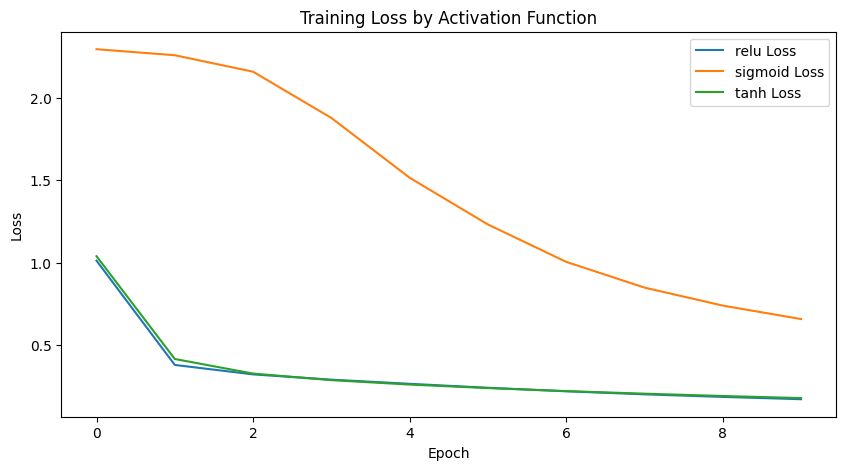

In [ ]:
# --- PROBLEM 1: MLP Implementation ---

class FlexibleMLP(nn.Module):
    def __init__(self, layer_sizes, activation_name='relu', dropout_p=0.0):
        super(FlexibleMLP, self).__init__()
        layers = []

        # Select activation function
        if activation_name == 'relu':
            act_fn = nn.ReLU()
        elif activation_name == 'sigmoid':
            act_fn = nn.Sigmoid()
        elif activation_name == 'tanh':
            act_fn = nn.Tanh()
        else:
            raise ValueError("Unknown activation")

        # Build layers dynamically
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: # No activation/dropout on last layer
                layers.append(act_fn)
                if dropout_p > 0:
                    layers.append(nn.Dropout(dropout_p))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Load Data
train_loader, test_loader = get_mnist_loaders()
layer_sizes = [784, 128, 64, 10]

# Dictionary to store results
results_p1 = {}

# Train with different activations
activations = ['relu', 'sigmoid', 'tanh']

for act in activations:
    print(f"\nTraining with {act}...")
    model = FlexibleMLP(layer_sizes, activation_name=act)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    losses, accs, _ = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)
    results_p1[act] = {'loss': losses, 'acc': accs}

# Plotting results for Problem 1
plt.figure(figsize=(10, 5))
for act in activations:
    plt.plot(results_p1[act]['loss'], label=f'{act} Loss')
plt.title('Training Loss by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# --- PROBLEM 1.3: XOR ---

# XOR Data
X_xor = torch.tensor([[0,0], [0,1], [1,0], [1,1]], dtype=torch.float32)
y_xor = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class XOR_Net(nn.Module):
    def __init__(self):
        super(XOR_Net, self).__init__()
        self.layer1 = nn.Linear(2, 4)
        self.act1 = nn.Tanh() # Tanh often works well for XOR
        self.layer2 = nn.Linear(4, 1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.output_act(self.layer2(x))
        return x

xor_model = XOR_Net()
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.Adam(xor_model.parameters(), lr=0.05)

print("\nTraining XOR Model...")
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = xor_model(X_xor)
    loss = criterion(outputs, y_xor)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Final Predictions
print("\nXOR Predictions:")
with torch.no_grad():
    print(xor_model(X_xor).round())


Training XOR Model...
Epoch 0, Loss: 0.7593
Epoch 200, Loss: 0.0045
Epoch 400, Loss: 0.0016
Epoch 600, Loss: 0.0009
Epoch 800, Loss: 0.0006

XOR Predictions:
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [1]:
# --- ADDITION TO PROBLEM 1.3: Decision Boundary Visualization ---

def plot_decision_boundary(model, X, y):
    # Create a mesh grid
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict for all points in grid
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = Z.reshape(xx.shape)

    # Plot contour
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu, s=100)
    plt.title("XOR Decision Boundary")
    plt.show()

plot_decision_boundary(xor_model, X_xor, y_xor)

NameError: name 'xor_model' is not defined


Training with SGD...
Epoch [1/20], Loss: 1.0022, Test Acc: 88.08%
Epoch [2/20], Loss: 0.3805, Test Acc: 90.88%
Epoch [3/20], Loss: 0.3239, Test Acc: 91.78%
Epoch [4/20], Loss: 0.2930, Test Acc: 91.60%
Epoch [5/20], Loss: 0.2680, Test Acc: 91.01%
Epoch [6/20], Loss: 0.2469, Test Acc: 92.96%
Epoch [7/20], Loss: 0.2275, Test Acc: 93.86%
Epoch [8/20], Loss: 0.2106, Test Acc: 94.37%
Epoch [9/20], Loss: 0.1956, Test Acc: 94.40%
Epoch [10/20], Loss: 0.1814, Test Acc: 94.82%
Epoch [11/20], Loss: 0.1693, Test Acc: 95.15%
Epoch [12/20], Loss: 0.1572, Test Acc: 94.98%
Epoch [13/20], Loss: 0.1481, Test Acc: 95.55%
Epoch [14/20], Loss: 0.1390, Test Acc: 95.80%
Epoch [15/20], Loss: 0.1314, Test Acc: 95.72%
Epoch [16/20], Loss: 0.1238, Test Acc: 96.08%
Epoch [17/20], Loss: 0.1171, Test Acc: 96.38%
Epoch [18/20], Loss: 0.1104, Test Acc: 96.22%
Epoch [19/20], Loss: 0.1050, Test Acc: 96.32%
Epoch [20/20], Loss: 0.1002, Test Acc: 96.36%

Training with SGD_Momentum...
Epoch [1/20], Loss: 0.4364, Test Acc

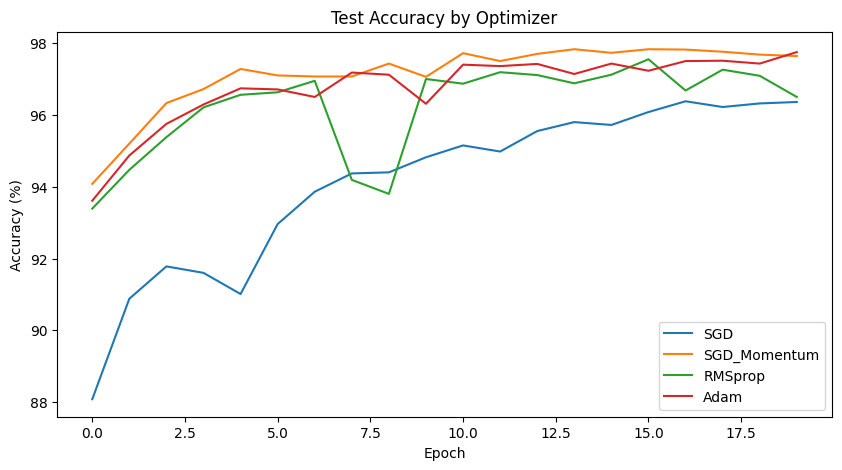

In [ ]:
# --- PROBLEM 2.1: Optimizers ---

optimizers_list = ['SGD', 'SGD_Momentum', 'RMSprop', 'Adam']
results_p2 = {}

for opt_name in optimizers_list:
    print(f"\nTraining with {opt_name}...")
    model = FlexibleMLP([784, 128, 64, 10], activation_name='relu')
    criterion = nn.CrossEntropyLoss()

    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif opt_name == 'SGD_Momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif opt_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train for 20 epochs as requested
    losses, accs, t_time = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20)
    results_p2[opt_name] = {'loss': losses, 'acc': accs, 'time': t_time}

# Compare Test Accuracy
plt.figure(figsize=(10, 5))
for opt_name in optimizers_list:
    plt.plot(results_p2[opt_name]['acc'], label=opt_name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

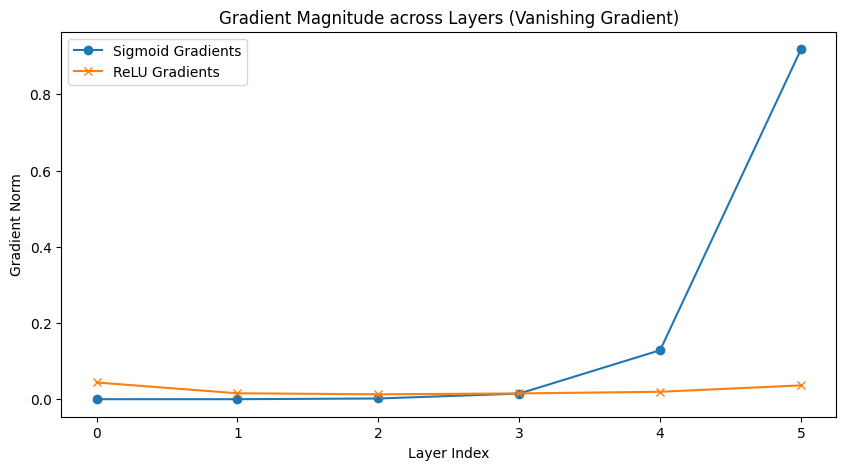

In [ ]:
# --- PROBLEM 2.2: Gradient Analysis ---

class DeepMLP(nn.Module):
    def __init__(self, activation_fn):
        super(DeepMLP, self).__init__()
        self.layers = nn.ModuleList()
        dims = [784, 100, 100, 100, 100, 100, 10] # 5 hidden layers
        self.activation = activation_fn

        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(len(self.layers)-1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x) # No activation on output
        return x

def track_gradients(model_act_name):
    if model_act_name == 'sigmoid':
        act = nn.Sigmoid()
    else:
        act = nn.ReLU()

    model = DeepMLP(act).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05)
    criterion = nn.CrossEntropyLoss()

    # Get one batch just to compute gradients
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    # Calculate gradient norms per layer
    grads = []
    for layer in model.layers:
        grads.append(layer.weight.grad.norm().item())

    return grads

# Compare Gradients
sigmoid_grads = track_gradients('sigmoid')
relu_grads = track_gradients('relu')

plt.figure(figsize=(10, 5))
plt.plot(sigmoid_grads, label='Sigmoid Gradients', marker='o')
plt.plot(relu_grads, label='ReLU Gradients', marker='x')
plt.title('Gradient Magnitude across Layers (Vanishing Gradient)')
plt.xlabel('Layer Index')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

In [ ]:
# --- PROBLEM 2.3: Regularization ---

configs = ['Baseline', 'L2_Regularization', 'Dropout']
results_reg = {}

for config in configs:
    print(f"\nTraining config: {config}")

    # Setup Dropout
    p = 0.5 if config == 'Dropout' else 0.0
    model = FlexibleMLP([784, 128, 64, 10], activation_name='relu', dropout_p=p)

    # Setup L2 (Weight Decay)
    wd = 0.001 if config == 'L2_Regularization' else 0.0
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    losses, accs, _ = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)
    results_reg[config] = accs[-1] # Save final accuracy

print("\nFinal Test Accuracies:")
for k, v in results_reg.items():
    print(f"{k}: {v:.2f}%")


Training config: Baseline
Epoch [1/15], Loss: 0.3864, Test Acc: 93.83%
Epoch [2/15], Loss: 0.1759, Test Acc: 95.04%
Epoch [3/15], Loss: 0.1296, Test Acc: 96.30%
Epoch [4/15], Loss: 0.1075, Test Acc: 97.10%
Epoch [5/15], Loss: 0.0890, Test Acc: 96.48%
Epoch [6/15], Loss: 0.0809, Test Acc: 97.28%
Epoch [7/15], Loss: 0.0715, Test Acc: 97.20%
Epoch [8/15], Loss: 0.0643, Test Acc: 97.17%
Epoch [9/15], Loss: 0.0583, Test Acc: 97.33%
Epoch [10/15], Loss: 0.0525, Test Acc: 97.34%
Epoch [11/15], Loss: 0.0469, Test Acc: 97.38%
Epoch [12/15], Loss: 0.0455, Test Acc: 97.68%
Epoch [13/15], Loss: 0.0401, Test Acc: 96.85%
Epoch [14/15], Loss: 0.0389, Test Acc: 97.64%
Epoch [15/15], Loss: 0.0372, Test Acc: 97.58%

Training config: L2_Regularization
Epoch [1/15], Loss: 0.3956, Test Acc: 92.87%
Epoch [2/15], Loss: 0.1986, Test Acc: 95.09%
Epoch [3/15], Loss: 0.1483, Test Acc: 95.77%
Epoch [4/15], Loss: 0.1277, Test Acc: 96.35%
Epoch [5/15], Loss: 0.1132, Test Acc: 96.67%
Epoch [6/15], Loss: 0.1063, Tes

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]



Training CNN on CIFAR-10...
Epoch [1/20], Loss: 1.3505, Test Acc: 61.72%
Epoch [2/20], Loss: 0.9773, Test Acc: 66.31%
Epoch [3/20], Loss: 0.8166, Test Acc: 69.78%
Epoch [4/20], Loss: 0.6917, Test Acc: 71.89%
Epoch [5/20], Loss: 0.5841, Test Acc: 72.20%
Epoch [6/20], Loss: 0.4878, Test Acc: 71.83%
Epoch [7/20], Loss: 0.4020, Test Acc: 72.22%
Epoch [8/20], Loss: 0.3199, Test Acc: 71.86%
Epoch [9/20], Loss: 0.2477, Test Acc: 71.38%
Epoch [10/20], Loss: 0.1990, Test Acc: 71.39%
Epoch [11/20], Loss: 0.1520, Test Acc: 70.43%
Epoch [12/20], Loss: 0.1258, Test Acc: 70.93%
Epoch [13/20], Loss: 0.1048, Test Acc: 69.85%
Epoch [14/20], Loss: 0.0946, Test Acc: 70.44%
Epoch [15/20], Loss: 0.0785, Test Acc: 70.70%
Epoch [16/20], Loss: 0.0752, Test Acc: 70.81%
Epoch [17/20], Loss: 0.0705, Test Acc: 70.33%
Epoch [18/20], Loss: 0.0678, Test Acc: 70.41%
Epoch [19/20], Loss: 0.0606, Test Acc: 70.15%
Epoch [20/20], Loss: 0.0643, Test Acc: 70.87%


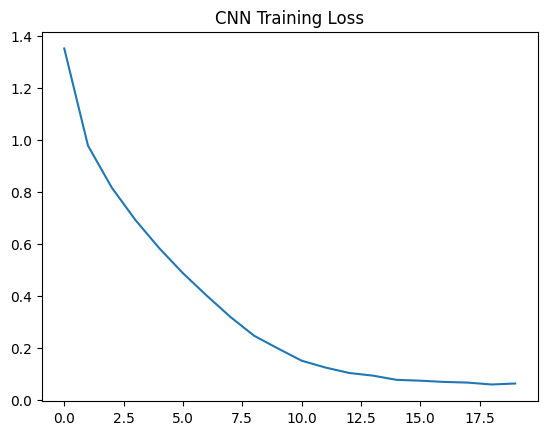

In [ ]:
# --- PROBLEM 3: CNN ---

# Load CIFAR-10
train_loader_cifar, test_loader_cifar = get_cifar_loaders()

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Conv Layer 1: 32 filters, 3x3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Conv Layer 2: 64 filters, 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # FC Layers
        # Input image is 32x32 -> Pool -> 16x16 -> Pool -> 8x8
        # Flatten size = 64 filters * 8 * 8
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("\nTraining CNN on CIFAR-10...")
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train for 20 epochs
losses_cnn, accs_cnn, _ = train_model(cnn_model, train_loader_cifar, test_loader_cifar, criterion, optimizer, epochs=20)

plt.plot(losses_cnn)
plt.title('CNN Training Loss')
plt.show()

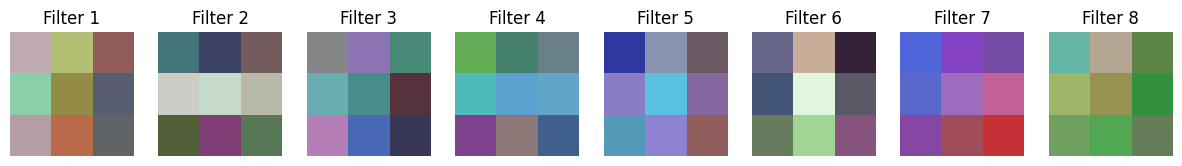

In [ ]:
# --- PROBLEM 3.3: Visualize Filters ---

# Get weights from the first layer
filters = cnn_model.conv1.weight.data.cpu()

# Normalize filters for better visualization (0 to 1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot first 8 filters
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    # Permute to (H, W, C) for matplotlib
    f = filters[i].permute(1, 2, 0)
    axes[i].imshow(f)
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')
plt.show()


--- Starting Bonus Task: Transfer Learning (ResNet18) ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Fine-tuning pre-trained model...
Epoch [1/5], Loss: 1.7344, Test Acc: 44.02%
Epoch [2/5], Loss: 1.5995, Test Acc: 45.06%
Epoch [3/5], Loss: 1.5811, Test Acc: 43.85%
Epoch [4/5], Loss: 1.5750, Test Acc: 45.39%
Epoch [5/5], Loss: 1.5681, Test Acc: 46.14%

Final Accuracy (Simple CNN): 70.87%
Final Accuracy (Transfer Learning): 46.14%
Conclusion: Simple CNN performed better (unexpected).


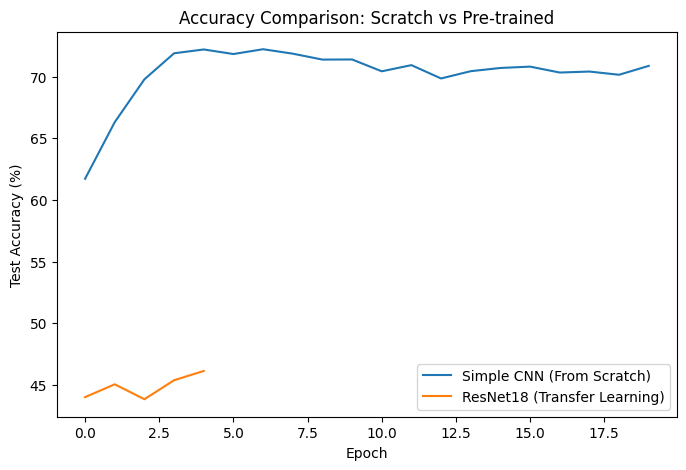

In [ ]:
# --- BONUS TASK: Transfer Learning ---

print("\n--- Starting Bonus Task: Transfer Learning (ResNet18) ---")

# 1. Load Pre-trained ResNet18 model
# 'DEFAULT' weights means it loads the best available pre-trained weights
transfer_model = torchvision.models.resnet18(weights='DEFAULT')

# 2. Freeze all layers (so we don't destroy pre-trained features)
# This makes training much faster
for param in transfer_model.parameters():
    param.requires_grad = False

# 3. Replace the final fully connected layer
# ResNet18's last layer is called 'fc' and has 512 input features
num_ftrs = transfer_model.fc.in_features
transfer_model.fc = nn.Linear(num_ftrs, 10) # Change output to 10 classes (CIFAR-10)

# Move model to GPU
transfer_model = transfer_model.to(device)

# 4. Setup Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize the parameters of the final layer (transfer_model.fc)
optimizer = optim.Adam(transfer_model.fc.parameters(), lr=0.001)

# 5. Train the model (Fine-tuning)
# We only need fewer epochs because the model is already smart
print("Fine-tuning pre-trained model...")
losses_tl, accs_tl, time_tl = train_model(transfer_model, train_loader_cifar, test_loader_cifar, criterion, optimizer, epochs=5)

# 6. Compare results
print(f"\nFinal Accuracy (Simple CNN): {accs_cnn[-1]:.2f}%")
print(f"Final Accuracy (Transfer Learning): {accs_tl[-1]:.2f}%")

if accs_tl[-1] > accs_cnn[-1]:
    print("Conclusion: Transfer learning performed better.")
else:
    print("Conclusion: Simple CNN performed better (unexpected).")

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(accs_cnn, label='Simple CNN (From Scratch)')
plt.plot(accs_tl, label='ResNet18 (Transfer Learning)')
plt.title('Accuracy Comparison: Scratch vs Pre-trained')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()

In [6]:
# --- PROBLEM 3.2: Architecture Experimentation ---

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Model A: Deeper Network (3 Conv Layers)
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model B: Wide Network
class WideCNN(nn.Module):
    def __init__(self):
        super(WideCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class LargeKernelCNN(nn.Module):
    def __init__(self):
        super(LargeKernelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


models = {
    'Deep (3 Layers)': DeepCNN(),
    'Wide (More Filters)': WideCNN(),
    'Large Kernel (5x5)': LargeKernelCNN()
}

results_arch = {}

print("Starting comparison...")

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)




    losses, accs, t_time = train_model(model, train_loader_cifar, test_loader_cifar, criterion, optimizer, epochs=10)

    results_arch[name] = {'acc': accs, 'time': t_time, 'final_acc': accs[-1]}

# --- Results ---
print(f"\n{'Architecture':<25} | {'Time (s)':<10} | {'Test Acc (%)':<10}")
print("-" * 50)
for name, res in results_arch.items():
    print(f"{name:<25} | {res['time']:.1f}       | {res['final_acc']:.2f}")

# --- Graps ---
plt.figure(figsize=(10, 6))
for name, res in results_arch.items():
    plt.plot(res['acc'], label=f"{name} (Final: {res['final_acc']:.1f}%)")
plt.title('Architecture Experimentation: Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()

Starting comparison...

Training Deep (3 Layers)...


NameError: name 'train_model' is not defined